We will work on this notebook to implement the algorithm.
Please check regularly for updates.

Main tasks:
1. Write the code for the algorithm
2. Find better $\alpha$ and $\beta$ values for the model.
3. Find stopping criteria for the model.
4. Apply the new hyperparameters to the algorithm, and evaluate the results on a lexical similarity task, then on a sentiment analysis task.

In [1]:
# Importing the libraries:
import numpy as np
import gensim.models.word2vec as w2v
import gensim.downloader as api
import math
import re
from copy import deepcopy
import sys
import gzip
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Define a read vectors function to read the vectors from the file
def read_vectors_file(filename):
    word_vectors = {}
    with gzip.open(filename, 'rt', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split()
                word = parts[0]
                vector = [float(x) for x in parts[1:]]
                word_vectors[word] = np.array(vector) # Convert to numpy array for later use in the code
    return word_vectors

# Read the vectors from the file as a dictionary
vectors = read_vectors_file('vectors_datatxt_250_sg_w10_i5_c500_gensim_clean.gz')

In [3]:
print(f"The vocabulary size is {len(vectors)}")
print(f"The vector size is {len(vectors['the'])}")
print(vectors['the'])

The vocabulary size is 125777
The vector size is 250
[ 2.16749e-01 -1.84148e-01  1.16644e-01 -9.11750e-02 -9.30600e-02
 -2.44480e-02 -9.81810e-02  1.36277e-01  3.13000e-03  1.32696e-01
 -2.18930e-02  5.00290e-02  9.29950e-02  1.01006e-01 -2.72782e-01
  6.58980e-02  7.98310e-02  1.20830e-01  1.83800e-03  1.09131e-01
 -1.97052e-01 -1.57743e-01 -8.70130e-02 -2.88130e-02 -3.17270e-02
 -5.69130e-02 -1.90135e-01 -8.91000e-03  9.18300e-03 -1.76240e-01
 -2.60480e-02  5.36160e-02 -1.87425e-01 -4.40870e-02  5.22380e-02
  1.50861e-01  1.00894e-01 -1.04502e-01  8.82450e-02  1.24603e-01
  6.53740e-02 -2.40738e-01  1.36660e-01 -1.86156e-01  9.86000e-04
 -1.45817e-01 -5.92010e-02 -1.90453e-01  3.65760e-02 -6.44750e-02
  2.49990e-02 -1.95380e-02  1.58472e-01 -1.87950e-01  4.67110e-02
  1.47299e-01  4.59230e-02  9.47430e-02  2.03657e-01  8.17700e-02
  3.84720e-02  3.61040e-02 -3.33310e-02  6.79180e-02  1.37791e-01
  3.22300e-02 -2.24442e-01  1.70670e-02  4.42260e-02  5.49500e-02
  1.08627e-01  5.26030e

In [4]:
# Toy corpus of 10 words:
toy_corpus = ['frog', 'toad', 'berger', 'cat', 'cheetah', 'dog', 'feline', 'true', 'false', 'incorrect']

# Vectorize the toy corpus:
vec_toy_corpus = [vectors[word] for word in toy_corpus]


In [5]:
# These are the way when I used the gensim model. It's just too large or my laptop to run.
# Load the word2vec model:
#wv = api.load('word2vec-google-news-300')
#wv = w2v.Word2Vec(vector_size=250, min_count=500, window=8, sample=1e-3, workers=8, sg=1, hs=0, negative=10, epochs=5)

# Vectorize the toy corpus:
#vec_toy_corpus = [wv.wv[word] for word in toy_corpus]
#vec_toy_corpus = [wv[word] for word in toy_corpus]


In [101]:
# Compare vectors using cosine similarity:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Compute the cosine similarity matrix:
similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        similarity_matrix[i][j] = cosine_similarity(vec_toy_corpus[i], vec_toy_corpus[j])
print(f"The similarity between cat and feline is: {similarity_matrix[3][6]:.4f}")
# Print the cosine similarity matrix:
#for i in range(len(vec_toy_corpus)):
#    for j in range(len(vec_toy_corpus)):
#        print(f'Similarity between {toy_corpus[i]} and {toy_corpus[j]} is {similarity_matrix[i][j]:.4f}')

The similarity between cat and feline is: 0.5670


# 1. Implementing the algorithm and finding the best hyperparameters.

In [102]:
# We implement the retrofitting algorithm of Faruqui et al. (2015):
# Preprocessing the data:
isNumber = re.compile(r'\d+.*')
def norm_word(word):
  if isNumber.search(word.lower()):
    return '---num---'
  elif re.sub(r'\W+', '', word) == '':
    return '---punc---'
  else:
    return word.lower()

# Read all the word vectors and normalize them:
def read_word_vecs(filename):
  wordVectors = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r')
  
  for line in fileObject:
    line = line.strip().lower()
    word = line.split()[0]
    wordVectors[word] = np.zeros(len(line.split())-1, dtype=float)
    for index, vecVal in enumerate(line.split()[1:]):
      wordVectors[word][index] = float(vecVal)
    ''' normalize weight vector '''
    wordVectors[word] /= math.sqrt((wordVectors[word]**2).sum() + 1e-6)
    
  sys.stderr.write("Vectors read from: "+filename+" \n")
  return wordVectors

# Read lexicon as a dictionary:
def read_lexicon(filename):
  lexicon = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r')
  
  for line in fileObject:
    words = line.lower().strip().split()
    lexicon[norm_word(words[0])] = [norm_word(word) for word in words[1:]]
  return lexicon

# Retrofit word vectors to a lexicon:
def retrofit(wordVecs, lexicon, numIters, alpha = 1, beta = 2): # wordVecs is a dictionary
  newWordVecs = deepcopy(wordVecs)
  wvVocab = set(newWordVecs.keys())
  loopVocab = wvVocab.intersection(set(lexicon.keys()))
  for it in range(numIters):
    # loop through every node also in ontology (else just use data estimate)
    for word in loopVocab:
      wordNeighbours = set(lexicon[word]).intersection(wvVocab)
      numNeighbours = len(wordNeighbours)
      #no neighbours, pass - use data estimate
      if numNeighbours == 0:
        continue
      # the weight of the old vector is alpha
      newVec = alpha * wordVecs[word]
      # loop over neighbours and add to new vector (currently with weight beta)
      for ppWord in wordNeighbours:
        newVec += beta * newWordVecs[ppWord] / numNeighbours
      newWordVecs[word] = newVec/(alpha + beta*1) # 1/numNeighbours * numNeighbours = 1
  return newWordVecs

In [103]:
# Transform the toy corpus into a wordVecs dictionary:
toy_wordVecs = {}
for i in range(len(vec_toy_corpus)):
    toy_wordVecs[toy_corpus[i]] = vec_toy_corpus[i]
print(toy_wordVecs.keys())

dict_keys(['frog', 'toad', 'berger', 'cat', 'cheetah', 'dog', 'feline', 'true', 'false', 'incorrect'])


In [104]:
# Read the lexicon. We can use NLTK WordNet.
lexicon = {}
# The idea is to create a dictionary where the keys are the words in the corpus
# and the values are the words that are related to the key word from the WordNet.
for synset in wn.all_synsets():
    for lemma in synset.lemmas():
        word = lemma.name()
        if word not in lexicon:
            lexicon[word] = []
        for related_synset in synset.hyponyms() + synset.hypernyms() + synset.part_meronyms() + synset.part_holonyms() + synset.member_holonyms() + synset.member_meronyms():
            for related_lemma in related_synset.lemmas():
                related_word = related_lemma.name()
                if related_word != word:
                    lexicon[word].append(related_word)


In [105]:
# We can take a peek at the lexicon too:
print(lexicon['cat'])

['domestic_cat', 'house_cat', 'Felis_domesticus', 'Felis_catus', 'wildcat', 'feline', 'felid', 'cheetah', 'chetah', 'Acinonyx_jubatus', 'jaguar', 'panther', 'Panthera_onca', 'Felis_onca', 'leopard', 'Panthera_pardus', 'liger', 'lion', 'king_of_beasts', 'Panthera_leo', 'saber-toothed_tiger', 'sabertooth', 'snow_leopard', 'ounce', 'Panthera_uncia', 'tiger', 'Panthera_tigris', 'tiglon', 'tigon', 'feline', 'felid', 'Felidae', 'family_Felidae', 'tracked_vehicle', 'whip', 'stimulant', 'stimulant_drug', 'excitant', 'gossip', 'gossiper', 'gossipmonger', 'rumormonger', 'rumourmonger', 'newsmonger', 'woman', 'adult_female', 'sod', 'man', 'adult_male', 'excrete', 'egest', 'eliminate', 'pass', 'flog', 'welt', 'whip', 'lather', 'lash', 'slash', 'strap', 'trounce']


In [135]:
# Retrofit the word vectors using basic hyperparameters:
newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = 10, alpha = 1, beta = 2)

# Similarity matrix after retrofitting:
retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
        
# Print the cosine similarity matrix:
retrofit_effect_matrix = retro_similarity_matrix - similarity_matrix
print(f"The similarity between cat and feline is: {retro_similarity_matrix[3][6]:.4f}")
#print('Retrofitting effect matrix: ')
#print(retrofit_effect_matrix)


print(f'Similarity is changed by {retrofit_effect_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
print(f'Similarity is changed by {retrofit_effect_matrix[2][5]:.4f} between {toy_corpus[2]} and {toy_corpus[5]}')
print(f'Similarity is changed by {retrofit_effect_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')

print('There has been some improvements in the toy corpus, so the retrofit algorithm works! We can move on to find the better hyperparameters.')

The similarity between cat and feline is: 0.9609
Similarity is changed by 0.3939 between cat and feline
Similarity is changed by 0.0000 between berger and dog
Similarity is changed by 0.4995 between cat and cheetah
There has been some improvements in the toy corpus, so the retrofit algorithm works! We can move on to find the better hyperparameters.


Alpha is 0.1
Similarity is changed by 0.4325 between cat and feline
Similarity is changed by 0.5515 between cat and cheetah
Alpha is 0.4
Similarity is changed by 0.4237 between cat and feline
Similarity is changed by 0.5399 between cat and cheetah
Alpha is 0.7
Similarity is changed by 0.4097 between cat and feline
Similarity is changed by 0.5210 between cat and cheetah
Alpha is 1.0
Similarity is changed by 0.3939 between cat and feline
Similarity is changed by 0.4995 between cat and cheetah
Alpha is 1.3
Similarity is changed by 0.3778 between cat and feline
Similarity is changed by 0.4775 between cat and cheetah
Alpha is 1.6
Similarity is changed by 0.3621 between cat and feline
Similarity is changed by 0.4561 between cat and cheetah
Alpha is 1.9
Similarity is changed by 0.3471 between cat and feline
Similarity is changed by 0.4357 between cat and cheetah
Alpha is 2.2
Similarity is changed by 0.3329 between cat and feline
Similarity is changed by 0.4165 between cat and cheetah
Alpha is

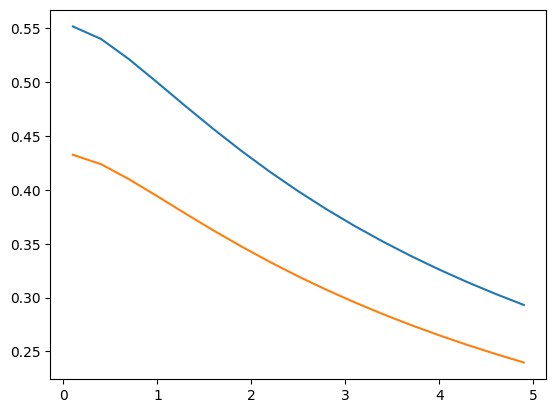

The best alpha is 1 for feline and 1 for cheetah


In [136]:
# Test different hyperparameters:
# Test alpha:
improvement_cheetah = []
improvement_feline = []
for alpha in np.arange(0.1, 5.1, 0.3):
    newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = 10, alpha = alpha, beta = 2)
    retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
    for i in range(len(vec_toy_corpus)):
        for j in range(len(vec_toy_corpus)):
            retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
    print(f'Alpha is {alpha:.1f}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][6] - similarity_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][4] - similarity_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')
    improvement_feline.append(retro_similarity_matrix[3][6] - similarity_matrix[3][6])
    improvement_cheetah.append(retro_similarity_matrix[3][4] - similarity_matrix[3][4])

# Plot the results:
plt.plot(np.arange(0.1, 5.1, 0.3), improvement_cheetah, label = 'cheetah')
plt.plot(np.arange(0.1, 5.1, 0.3), improvement_feline, label = 'feline')
plt.show()
print(f"The best alpha is {np.argmax(improvement_feline) + 1} for feline and {np.argmax(improvement_cheetah) + 1} for cheetah")

Beta is 1
Similarity is changed by 0.3423 between cat and feline
Similarity is changed by 0.4292 between cat and cheetah
Beta is 2
Similarity is changed by 0.3939 between cat and feline
Similarity is changed by 0.4995 between cat and cheetah
Beta is 3
Similarity is changed by 0.4114 between cat and feline
Similarity is changed by 0.5232 between cat and cheetah
Beta is 4
Similarity is changed by 0.4194 between cat and feline
Similarity is changed by 0.5341 between cat and cheetah
Beta is 5
Similarity is changed by 0.4237 between cat and feline
Similarity is changed by 0.5399 between cat and cheetah
Beta is 6
Similarity is changed by 0.4263 between cat and feline
Similarity is changed by 0.5434 between cat and cheetah
Beta is 7
Similarity is changed by 0.4280 between cat and feline
Similarity is changed by 0.5456 between cat and cheetah
Beta is 8
Similarity is changed by 0.4292 between cat and feline
Similarity is changed by 0.5472 between cat and cheetah
Beta is 9
Similarity is changed 

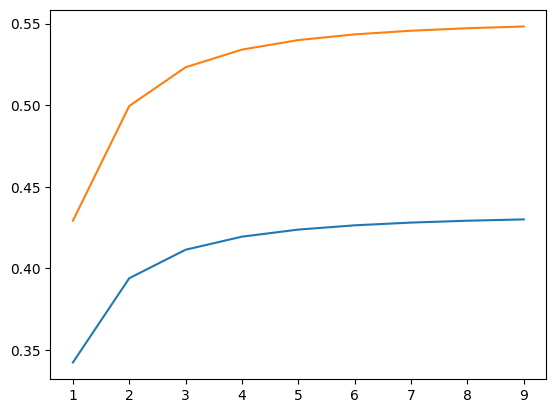

The best beta is 9 for feline and 9 for cheetah


In [137]:
# Test beta:
improvement_feline = []
improvement_cheetah = []
for beta in range(1, 10):
    newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = 10, alpha = 1, beta = beta)
    retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
    for i in range(len(vec_toy_corpus)):
        for j in range(len(vec_toy_corpus)):
            retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
    improvement_feline.append(retro_similarity_matrix[3][6] - similarity_matrix[3][6])
    improvement_cheetah.append(retro_similarity_matrix[3][4] - similarity_matrix[3][4])
    print(f'Beta is {beta}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][6] - similarity_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][4] - similarity_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')

# Plot the results:
plt.plot(range(1, 10), improvement_feline, label = 'feline')
plt.plot(range(1, 10), improvement_cheetah, label = 'cheetah')
plt.show()
print(f"The best beta is {np.argmax(improvement_feline) + 1} for feline and {np.argmax(improvement_cheetah) + 1} for cheetah")

Number of iterations is 1
Similarity is changed by 0.4073 between cat and feline
Similarity is changed by 0.5198 between cat and cheetah
Number of iterations is 2
Similarity is changed by 0.4009 between cat and feline
Similarity is changed by 0.5095 between cat and cheetah
Number of iterations is 3
Similarity is changed by 0.3972 between cat and feline
Similarity is changed by 0.5041 between cat and cheetah
Number of iterations is 4
Similarity is changed by 0.3954 between cat and feline
Similarity is changed by 0.5015 between cat and cheetah
Number of iterations is 5
Similarity is changed by 0.3946 between cat and feline
Similarity is changed by 0.5004 between cat and cheetah
Number of iterations is 6
Similarity is changed by 0.3942 between cat and feline
Similarity is changed by 0.4999 between cat and cheetah
Number of iterations is 7
Similarity is changed by 0.3940 between cat and feline
Similarity is changed by 0.4996 between cat and cheetah
Number of iterations is 8
Similarity is c

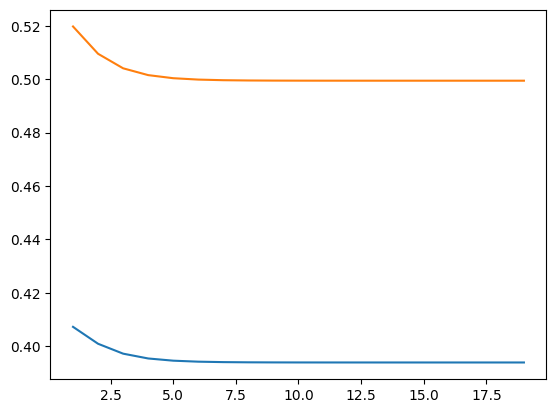

The best number of Iteration is 1 for feline and 1 for cheetah


In [138]:
# Test number of iterations:
improvement_feline = []
improvement_cheetah = []
for iter in range(1, 20):
    newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = iter, alpha = 1, beta = 2)
    retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
    for i in range(len(vec_toy_corpus)):
        for j in range(len(vec_toy_corpus)):
            retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
    improvement_feline.append(retro_similarity_matrix[3][6] - similarity_matrix[3][6])
    improvement_cheetah.append(retro_similarity_matrix[3][4] - similarity_matrix[3][4])
    print(f'Number of iterations is {iter}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][6] - similarity_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][4] - similarity_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')

# Plot the results:
plt.plot(range(1, 20), improvement_feline, label = 'feline')
plt.plot(range(1, 20), improvement_cheetah, label = 'cheetah')
plt.show()
print(f"The best number of Iteration is {np.argmax(improvement_feline) + 1} for feline and {np.argmax(improvement_cheetah) + 1} for cheetah")

From these results, we can see that the performance of the retrofitting algorithm works best with this set of hyperparameters: alpha = 1, beta = 2, and nb_iter = 7, because the performance does not increase significantly when these hyperparameters are increased.

# 2. Implement the algorithm in matrix form.

In order to implement the retrofitting algorithm in the matrix form, we will assume that the input is the whole word embeddings matrix E(w), and the output is the whole word embeddings matrix E'(w). The retrofitting algorithm will be applied to the whole word embeddings matrix E(w) to get the whole word embeddings matrix E'(w).

To do this, we will have to change the way the lexicon works. At the moment, it is a dictionary with words as keys and their neighbors as values, but to have better performance on a larger vocabulary, it should have indices instead of words. This way, we can use the indices to access the word embeddings matrix E(w) and E'(w).

In [139]:
# Word ids and indices:
def build_word_index_mappings(word_vectors):
    word_to_index = {}
    index_to_word = []
    for i, word in enumerate(word_vectors.keys()):
        word_to_index[word] = i
        index_to_word.append(word)
    return word_to_index, index_to_word

word_ids, word_indices = build_word_index_mappings(vectors)


In [140]:
# Take a look at the lexicon:
print(word_ids['dog'])
print(lexicon['dog'])

2122
['basenji', 'corgi', 'Welsh_corgi', 'cur', 'mongrel', 'mutt', 'dalmatian', 'coach_dog', 'carriage_dog', 'Great_Pyrenees', 'griffon', 'Brussels_griffon', 'Belgian_griffon', 'hunting_dog', 'lapdog', 'Leonberg', 'Mexican_hairless', 'Newfoundland', 'Newfoundland_dog', 'pooch', 'doggie', 'doggy', 'barker', 'bow-wow', 'poodle', 'poodle_dog', 'pug', 'pug-dog', 'puppy', 'spitz', 'toy_dog', 'toy', 'working_dog', 'canine', 'canid', 'domestic_animal', 'domesticated_animal', 'flag', 'Canis', 'genus_Canis', 'pack', 'support', 'catch', 'stop', 'ratchet', 'rachet', 'ratch', 'Vienna_sausage', 'sausage', 'hotdog', 'hot_dog', 'red_hot', 'perisher', 'villain', 'scoundrel', 'chap', 'fellow', 'feller', 'fella', 'lad', 'gent', 'blighter', 'cuss', 'bloke', 'unpleasant_woman', 'disagreeable_woman', 'hound', 'hunt', 'trace', 'quest', 'run_down', 'tree', 'pursue', 'follow']


In [141]:
# Create a new dictionary to store the lexicon with word IDs
# This dictionary will have as keys the word IDs and as values the list of IDs of the words in the lexicon that are related to the key. The words not present in the vocabulary are ignored.
# This is done to ensure that the IDs of the words in the lexicon are the same as the IDs of the words in the vocabulary.
lexicon_with_ids = {}

# Using the same method as above, but this time we are using the word IDs instead of the words themselves
for synset in wn.all_synsets():
    for lemma in synset.lemmas():
        word = lemma.name()
        if word not in word_ids:
            continue
        if word not in lexicon_with_ids:
            lexicon_with_ids[word_ids[word]] = []
        for related_synset in synset.hyponyms() + synset.hypernyms() + synset.part_meronyms() + synset.part_holonyms() + synset.member_holonyms() + synset.member_meronyms():
            for related_lemma in related_synset.lemmas():
                related_word = related_lemma.name()
                if related_word in word_ids:
                    if related_word != word:
                        lexicon_with_ids[word_ids[word]].append(word_ids[related_word])

In [142]:
# Test new lexicon:
print(lexicon_with_ids.keys()) # List of word IDs
print(lexicon_with_ids.get(2122)) # dog

dict_keys([633, 2202, 13527, 23030, 42473, 21305, 30812, 4036, 5342, 37289, 117, 31095, 901, 9794, 46399, 56225, 26116, 5371, 1523, 16085, 104807, 8311, 294, 3385, 9661, 23456, 65157, 76944, 105562, 25529, 72004, 32080, 46598, 9119, 36436, 28236, 18482, 121117, 81650, 69621, 43906, 19990, 33157, 77219, 6899, 41732, 13421, 4748, 10829, 4030, 4970, 549, 16586, 11016, 117523, 42046, 13807, 32902, 21368, 2022, 36915, 1706, 31478, 16909, 91117, 86426, 62738, 5151, 207, 22680, 14961, 2401, 39703, 26317, 55350, 14378, 2256, 4541, 8471, 36101, 12363, 4356, 87096, 95601, 7678, 25527, 4920, 45411, 45484, 13718, 20987, 24841, 4106, 103515, 114984, 64779, 28195, 69307, 65085, 48508, 4009, 585, 9239, 8973, 1739, 1105, 251, 10653, 489, 706, 15054, 6248, 1277, 37211, 1220, 17018, 68550, 49, 8393, 21243, 3883, 26788, 1730, 4466, 2006, 2601, 5431, 360, 2509, 31428, 78688, 87898, 36726, 1788, 33546, 60334, 100527, 120628, 112100, 31370, 90487, 29877, 44500, 19348, 42595, 1186, 63, 32117, 2955, 55002, 22

In [143]:
# Create the embedding matrix:
embedding_matrix = np.zeros((len(word_indices), 250))

# Fill the embedding matrix with the word vectors from the word2vec model
for i in range(len(word_indices)):
    embedding_matrix[i] = vectors[word_indices[i]]   

In [144]:
# Create a neighbor matrix from the new lexicon:
# The value for each word is the sum of the embeddings of the words in the lexicon that are related to the word
neighbor_matrix = np.zeros((len(word_indices), 250)) # It's a matrix of size (vocab_size, 250)
# Fill the neighbor matrix:
# For each word in the lexicon, we sum the embeddings of the words in the lexicon that are related to the word
for key in lexicon_with_ids.keys():
    neighbor_matrix[key] = np.sum(embedding_matrix[lexicon_with_ids[key]], axis = 0)
# Create an array of number of neighbors for each word:
num_neighbors = np.zeros(len(word_indices))
for key in lexicon_with_ids.keys():
    num_neighbors[key] = len(lexicon_with_ids[key])
num_neighbors[num_neighbors == 0] = 1e-6 # To avoid division by 0

# Divide each row of the neighbor matrix by the number of neighbors for the corresponding word
neighbor_matrix = neighbor_matrix / num_neighbors[:, None]

In [145]:
print(lexicon_with_ids[word_ids['dog']]) # dog has 7 related words
print(embedding_matrix[lexicon_with_ids[word_ids['dog']]].shape) 
print(neighbor_matrix[word_ids['dog']].shape) # dog 
print(num_neighbors[word_ids['dog']]) # 7 related words

[19729, 3446, 7013, 6109, 1947, 4721, 1550]
(7, 250)
(250,)
7.0


In [146]:
# Define the retrofitting algorithm, using the previously found hyperparameters:
def retrofit_matrix(embedding_matrix, neighbor_matrix, alpha = 1, beta = 2, nb_iters = 10):
    new_embedding_matrix = embedding_matrix
    for i in range(nb_iters):
        new_embedding_matrix = (alpha * new_embedding_matrix + beta * neighbor_matrix) / (alpha + beta)
    return new_embedding_matrix

# Run the algorithm on the embedding matrix:
retrofitted_matrix = retrofit_matrix(embedding_matrix, neighbor_matrix, 1, 9, 2)

# 3. Evaluations.
We will evaluate the new retrofitted word embeddings on a lexical similarity task, and a sentiment analysis task.
## 3.1. Lexical similarity task.
We will use the WordSim353 dataset to evaluate the performance of the retrofitting algorithm on a lexical similarity task. The WordSim353 dataset contains 353 pairs of words, and each pair is assigned a similarity score by human annotators. The similarity score ranges from 0 to 10, with 0 being not similar at all, and 10 being very similar. We will use the cosine similarity between the word embeddings of each pair of words to calculate the similarity score, and then compare it with the human similarity score to see how well the retrofitting algorithm performs.

In [147]:
# Read the WordSim353 dataset as a pandas dataframe:
# It is done with pandas for ease of manipulation, and also ease of calculation of the correlation between the human scores and the cosine similarities
def read_ws353():
    with open('ws353.txt', 'r') as f:
        data = f.read()
    lines = data.split('\n')
    lines = lines[0:-1]
    word1 = []
    word2 = []
    human_scores = []
    for line in lines:
        tokens = line.split('\t')
        word1.append(tokens[0])
        word2.append(tokens[1])
        human_scores.append(float(tokens[2]))
    df = pd.DataFrame({'word1': word1, 'word2': word2, 'score': human_scores})

    return df

ws353_data = read_ws353()

In [148]:
print(ws353_data)

            word1     word2  score
0            love       sex   6.77
1           tiger       cat   7.35
2           tiger     tiger  10.00
3            book     paper   7.46
4        computer  keyboard   7.62
..            ...       ...    ...
348        shower     flood   6.03
349       weather  forecast   8.34
350      disaster      area   6.25
351      governor    office   6.34
352  architecture   century   3.78

[353 rows x 3 columns]


In [149]:
# Create a function to compute the cosine similarity between two words:
def emb_cosine_similarity(word1, word2, embedding_matrix):
    if word1 not in word_ids or word2 not in word_ids:
        return None
    word1_embedding = embedding_matrix[word_ids[word1]]
    word2_embedding = embedding_matrix[word_ids[word2]]
    return np.dot(word1_embedding, word2_embedding) / (np.linalg.norm(word1_embedding) * np.linalg.norm(word2_embedding))

# Calculate the score for each pair of words in the dataset:
ws353_data['original_score'] = ws353_data.apply(lambda row: emb_cosine_similarity(row['word1'], row['word2'], embedding_matrix), axis = 1)
ws353_data['retrofitted_score'] = ws353_data.apply(lambda row: emb_cosine_similarity(row['word1'], row['word2'], retrofitted_matrix), axis = 1)


In [150]:
# Because there are some words in the dataset that are not in the vocabulary, we need to remove them from the dataset before calculation of the correlation:
ws353_data = ws353_data.dropna()

# Calculate the Spearman correlation between the human scores and the model scores:
print(ws353_data[['score', 'original_score', 'retrofitted_score']].corr(method = 'spearman'))

                      score  original_score  retrofitted_score
score              1.000000        0.690526           0.165118
original_score     0.690526        1.000000           0.165223
retrofitted_score  0.165118        0.165223           1.000000


## 3.2. Sentiment analysis task.
We will use the Stanford Sentiment Treebank dataset to evaluate the performance of the retrofitting algorithm on a sentiment analysis task. The Stanford Sentiment Treebank dataset contains 11,855 sentences, and each sentence is assigned a sentiment score by human annotators. The sentiment score ranges between -1 and 1, with -1 as negative and 1 as positive. 

The two word embeddings will be used in a frozen way. We will train 2 neural network using the sentences vectorized by the two embeddings as input, and the sentiment scores as output. Then we will compare the predicted sentiment scores with original embeddings with the predicted sentiment scores with retrofitted embeddings to see how well the retrofitting algorithm performs. For this task, we will use accuracy as a metric to evaluate the performance of the retrofitting algorithm.

In [151]:
import torch

In [152]:
# Read the dataset from Stanford Sentiment Treebank:
def read_sst(filename):
    # Open the gzip file
    with gzip.open(filename, 'rt', encoding='utf-8') as f:
        # Read the data and split it into lines
        data = f.read()
        lines = data.split('\n')
        lines = lines[0:-1]
        
        # Initialize lists to store sentences and labels
        sentences = []
        labels = []
        
        # Loop over each line
        for line in lines:
            # Skip the header line
            if line.startswith('1') or line.startswith('-1'):
                # Split the line into tokens using space as the delimiter
                tokens = line.split(' ', 1)
            
                # Check if the tokens list contains at least two elements
                if len(tokens) >= 2:
                    # Append the label and sentence to the respective lists
                    labels.append(int(tokens[0]))
                    sentences.append(tokens[1])
        
        # Create a DataFrame from the sentences and labels
        df = pd.DataFrame({'sentence': sentences, 'label': labels})
    
    return df

# Read the dataset
dataset = read_sst('stanford_sentiment_analysis.tar.gz')


In [153]:
# Create a function to preprocess the sentences:
def preprocess_sentence(sentence):
    # Remove the HTML tags
    sentence = re.sub(r'<[^>]+>', '', sentence)
    
    # Remove any non-alphanumeric characters (except spaces)
    sentence = re.sub(r'[^a-zA-Z0-9 ]', '', sentence)
    
    # Remove extra spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Convert to lowercase
    sentence = sentence.lower()
    
    # Return the preprocessed sentence
    return sentence

# Preprocess the sentences
dataset['sentence'] = dataset['sentence'].apply(preprocess_sentence)

# Create a function to tokenize the sentences:
def tokenize_sentence(sentence):
    # Split the sentence into tokens
    tokens = sentence.split(' ')
    
    # Return the list of tokens
    return tokens

# Tokenize the sentences
dataset['tokens'] = dataset['sentence'].apply(tokenize_sentence)


In [154]:
# Vectorize the tokens using the embedding matrix:
def vectorize_tokens(tokens, embedding_matrix):
    # Initialize the vector
    vectors = np.zeros((len(tokens), 250))
    
    # Loop over the tokens
    for i in range(len(tokens)):
        # Check if the token is in the vocabulary
        if tokens[i] in word_ids:
            # Get the index of the token in the vocabulary
            index = word_ids[tokens[i]]
            
            # Get the vector of the token from the embedding matrix
            vectors[i] = embedding_matrix[index]
    
    # Return the vector
    return vectors

# Vectorize the tokens
dataset['original_vectors'] = dataset['tokens'].apply(lambda tokens: vectorize_tokens(tokens, embedding_matrix))
dataset['retrofitted_vectors'] = dataset['tokens'].apply(lambda tokens: vectorize_tokens(tokens, retrofitted_matrix))

In [155]:
print(len(dataset['tokens'][0]))
dataset['original_vectors'][0].shape

35


(35, 250)

In [156]:
# Calculate the vector for each sentence by averaging the vectors of the tokens:
def calculate_sentence_vector(vectors):
    # Calculate the average of all token vectors
    vector = np.mean(vectors, axis = 0)
    # Return the vector
    return vector

# Calculate the sentence vectors
dataset['ori_sentence_vector'] = dataset['original_vectors'].apply(calculate_sentence_vector)
dataset['retro_sentence_vector'] = dataset['retrofitted_vectors'].apply(calculate_sentence_vector)
dataset['label'] = dataset['label'].apply(lambda x: 1 if x == 1 else 0)

# Dropping the columns that are not needed:
dataset = dataset.drop(['sentence', 'tokens', 'original_vectors', 'retrofitted_vectors'], axis = 1)


In [157]:
# Create example sets for the original and retrofitted datasets:
dataset_original = [(dataset['ori_sentence_vector'][i], dataset['label'][i]) for i in range(len(dataset))]
dataset_retrofitted = [(dataset['retro_sentence_vector'][i], dataset['label'][i]) for i in range(len(dataset))]

# Split the dataset into train, dev, test sets:
from sklearn.model_selection import train_test_split
ori_train, ori_temp = train_test_split(dataset_original, test_size = 0.2, random_state = 0)
ori_dev, ori_test = train_test_split(ori_temp, test_size = 0.5, random_state = 0)

retro_train, retro_temp = train_test_split(dataset_retrofitted, test_size = 0.2, random_state = 0)
retro_dev, retro_test = train_test_split(retro_temp, test_size = 0.5, random_state = 0)


In [158]:
# Create a simple one hidden layer neural network:
class SentimentAnalysis(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, early_stop = False):
        super(SentimentAnalysis, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim) #[250, 100]
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim) #[100, 2]
        self.sigmoid = torch.nn.Sigmoid() # Sigmoid for binary classification
        self.activation = torch.nn.ReLU()
        self.early_stop = early_stop
        
    def forward(self, x):
        out = self.linear1(x) # [batch_size, 250] * [250, 100] = [batch_size, 100]
        out = self.activation(out) # [batch_size, 100]
        out = self.linear2(out) # [batch_size, 100] * [100, 2] = [batch_size, 2]
        out = self.sigmoid(out) # [batch_size, 2]
        return out

# Create the model for original embeddings:
model_original = SentimentAnalysis(250, 100, 2)
# Create the model for retrofitted embeddings:
model_retrofitted = SentimentAnalysis(250, 100, 2)


In [159]:
# Define the loss function and optimizer:
loss_function = torch.nn.CrossEntropyLoss()
optimizer_original = torch.optim.Adam(model_original.parameters(), lr = 0.001)
optimizer_retrofitted = torch.optim.Adam(model_retrofitted.parameters(), lr = 0.001)

from random import shuffle


Training the original model...
Epoch: 0
Loss on training set at epoch 0 : 151.672142
Epoch: 1
Loss on training set at epoch 1 : 132.618648
Epoch: 2
Loss on training set at epoch 2 : 127.093486
Epoch: 3
Loss on training set at epoch 3 : 124.842128
Epoch: 4
Loss on training set at epoch 4 : 123.904309
Epoch: 5
Loss on training set at epoch 5 : 122.926249
Epoch: 6
Loss on training set at epoch 6 : 122.143710
Epoch: 7
Loss on training set at epoch 7 : 121.717825
Epoch: 8
Loss on training set at epoch 8 : 121.113890
Epoch: 9
Loss on training set at epoch 9 : 121.233925


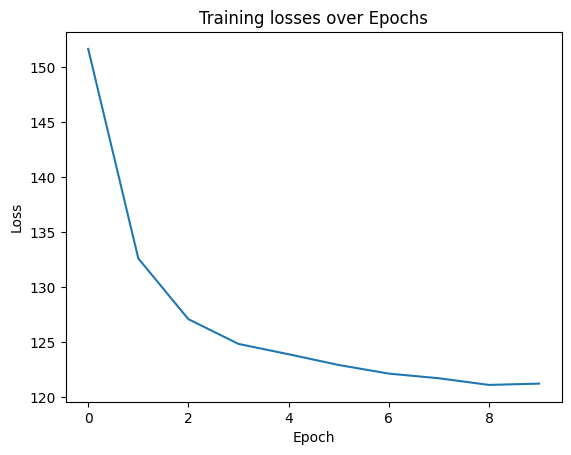

In [131]:
# Training the original model:
train_losses = []
print('Training the original model...')
for epoch in range(10):
    print('Epoch:', epoch)
    epoch_loss = 0
    shuffle(ori_train)
    i = 0
    # Process the training data in batches of 32:
    while i < len(ori_train):
        batch = ori_train[i:i+32]
        i += 32
        # Get the sentence vectors and labels from the batch:
        sentence, label = zip(*batch)
        
        # Step 1: Process the input data:
        sentence = torch.FloatTensor(sentence) # [batch_size, 250]
        label = torch.LongTensor(label) # [batch_size]
        
        # Step 2: Zero the gradients:
        model_original.zero_grad()
        
        # Step 3: Run the forward propagation:
        output = model_original(sentence)
        
        # Step 4: Compute loss and gradients:
        loss = loss_function(output, label)
        epoch_loss += loss.item()
        loss.backward()
        
        # Step 5: Update the weights:
        optimizer_original.step()
    # end of handling of this batch
    print("Loss on training set at epoch %d : %f" %(epoch, epoch_loss))
    train_losses.append(epoch_loss)    
    # Step 6: Early stopping:
    with torch.no_grad():
        if model_original.early_stop:
            # forward propagation
            # We convert the test examples to tensors and do the forward propagation
            dev_sentence, dev_label = zip(*ori_dev)
            dev_sentence = torch.tensor(dev_sentence, dtype=torch.float32) # [DEV_SIZE, CONTEXT_SIZE]
            dev_label = torch.tensor(dev_label, dtype=torch.long)   # [DEV_SIZE]        
            output = model_original(dev_sentence)    
                
            # total loss on the dev set
            dev_loss = loss_function(output, dev_label)
            print("Loss on dev set at epoch %d: %f\n" %(epoch, dev_loss))
                
            # prediction and accuracy on the dev set
            pred_labels = torch.argmax(output, dim=1)
            accuracy = torch.sum(pred_labels == dev_label).item() / len(dev_label)
            print("Accuracy on dev, after epoch %d: %3.2f\n" % (epoch, accuracy * 100))
                
            # early stopping
            # if first epoch: we record the dev loss, to be used for early stopping
            if epoch == 0:
                previous_dev_loss = dev_loss
            elif dev_loss > previous_dev_loss:
                print("Loss on dev has increased, we stop training!")
                break
            else:
                previous_dev_loss = dev_loss
# Plot the training losses
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training losses over Epochs")
plt.show()
        

In [132]:
# Test on test set after training:
with torch.no_grad():
    # forward propagation on test set
    test_sentence, test_label = zip(*ori_test)
    test_sentence = torch.tensor(test_sentence, dtype=torch.float32) # [DEV_SIZE, CONTEXT_SIZE]
    test_label = torch.tensor(test_label, dtype=torch.long)   # [DEV_SIZE]
    log_probs = model_original(test_sentence)
    
    # total loss on the test set
    test_loss = loss_function(log_probs, test_label)
    print("Loss on test set after training: %f\n" %(test_loss))
            
    # prediction and accuracy on the dev set
    pred_labels = torch.argmax(log_probs, dim=1)
    accuracy = torch.sum(pred_labels == test_label).item() / len(test_label)
    print("Accuracy on test after training: %3.2f\n" % (accuracy * 100))

Loss on test set after training: 0.507266

Accuracy on test after training: 78.98



Training the retrofitted model...
Epoch: 0
Loss on training set at epoch 0 : 166.415055
Epoch: 1
Loss on training set at epoch 1 : 164.233249
Epoch: 2
Loss on training set at epoch 2 : 161.559139
Epoch: 3
Loss on training set at epoch 3 : 159.448197
Epoch: 4
Loss on training set at epoch 4 : 158.071550
Epoch: 5
Loss on training set at epoch 5 : 157.103021
Epoch: 6
Loss on training set at epoch 6 : 155.975981
Epoch: 7
Loss on training set at epoch 7 : 155.276580
Epoch: 8
Loss on training set at epoch 8 : 154.711279
Epoch: 9
Loss on training set at epoch 9 : 154.232852


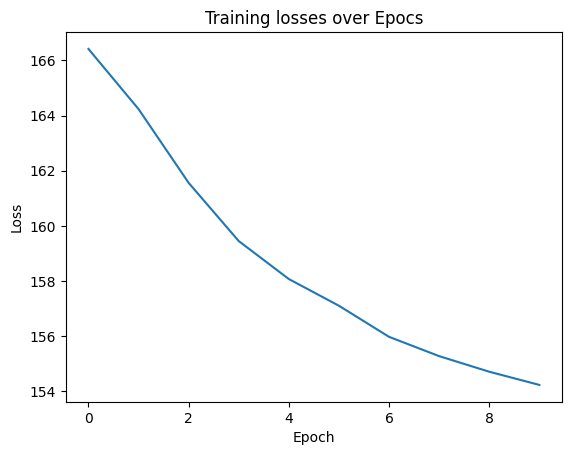

In [133]:
# Training the retrofitted model:
train_losses = []
print('Training the retrofitted model...')

for epoch in range(10):
    print('Epoch:', epoch)
    epoch_loss = 0
    shuffle(retro_train)
    i = 0
    # Process the training data in batches of 32:
    while i < len(retro_train):
        batch = retro_train[i:i+32]
        i += 32
        # Get the sentence vectors and labels from the batch:
        sentence, label = zip(*batch)
        
        # Step 1: Process the input data:
        sentence = torch.FloatTensor(sentence) # [batch_size, 250]
        label = torch.LongTensor(label) # [batch_size]
        
        # Step 2: Zero the gradients:
        model_retrofitted.zero_grad()
        
        # Step 3: Run the forward propagation:
        output = model_retrofitted(sentence)
        
        # Step 4: Compute loss and gradients:
        loss = loss_function(output, label)
        epoch_loss += loss.item()
        loss.backward()
        
        # Step 5: Update the weights:
        optimizer_retrofitted.step()
    # end of handling of this batch
    print("Loss on training set at epoch %d : %f" %(epoch, epoch_loss))
    train_losses.append(epoch_loss)    
        # Step 6: Early stopping:
    with torch.no_grad():
        if model_retrofitted.early_stop:
            # forward propagation
            # We convert the test examples to tensors and do the forward propagation
            dev_sentence, dev_label = zip(*retro_dev)
            dev_sentence = torch.tensor(dev_sentence, dtype=torch.float32) # [DEV_SIZE, CONTEXT_SIZE]
            dev_label = torch.tensor(dev_label, dtype=torch.long)   # [DEV_SIZE]        
            output = model_retrofitted(dev_sentence)    
                
            # total loss on the dev set
            dev_loss = loss_function(output, dev_label)
            print("Loss on dev set at epoch %d: %f\n" %(epoch, dev_loss))
                
            # prediction and accuracy on the dev set
            pred_labels = torch.argmax(output, dim=1)
            accuracy = torch.sum(pred_labels == dev_label).item() / len(dev_label)
            print("Accuracy on dev, after epoch %d: %3.2f\n" % (epoch, accuracy * 100))
                
            # early stopping
            # if first epoch: we record the dev loss, to be used for early stopping
            if epoch == 0:
                previous_dev_loss = dev_loss
            elif dev_loss > previous_dev_loss:
                print("Loss on dev has increased, we stop training!")
                break
            else:
                previous_dev_loss = dev_loss
# Plot the training losses
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training losses over Epocs")
plt.show()
        

In [134]:
# Test on test set after training:
with torch.no_grad():
    # forward propagation on test set
    test_sentence, test_label = zip(*retro_test)
    test_sentence = torch.tensor(test_sentence, dtype=torch.float32) # [DEV_SIZE, CONTEXT_SIZE]
    test_label = torch.tensor(test_label, dtype=torch.long)   # [DEV_SIZE]
    log_probs = model_retrofitted(test_sentence)
    
    # total loss on the test set
    test_loss = loss_function(log_probs, test_label)
    print("Loss on test set after training: %f\n" %(test_loss))
            
    # prediction and accuracy on the dev set
    pred_labels = torch.argmax(log_probs, dim=1)
    accuracy = torch.sum(pred_labels == test_label).item() / len(test_label)
    print("Accuracy on test after training: %3.2f\n" % (accuracy * 100))

Loss on test set after training: 0.658322

Accuracy on test after training: 61.71

